In [13]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import time
import copy
import matplotlib.pyplot as plt

Load Training Data ~ 300 images

Defining custom class for xception model

In [4]:
class Xception_Net(nn.Module):
    def __init__(
        self,
        num_classes: int = 2,
    ) -> None:
        super(Xception_Net, self).__init__()
        
        #Entry flow layer 1
        self.entry_flow_1 = nn.Sequential(
            #input channels for images is 3
            nn.Conv2d(3, 32, kernel_size = (3, 3), stride = (2, 2), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(32, 64, kernel_size = (3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True)
        )
        
        #Entry flow layer 2 - Separable convolution layer
        self.entry_flow_2_sep_conv = nn.Sequential(
            #performing depthwise and pointwise convolutions
            nn.Conv2d(64, 128, kernel_size = (3, 3), padding=1),
            nn.Conv2d(128, 128, kernel_size = (1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(128, 128, kernel_size = (3, 3), padding=1),
            nn.Conv2d(128, 128, kernel_size = (1, 1)),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size = (3, 3), stride = (2, 2), padding=1)
            
        )
        
        #Entry flow layer 2 - Residual Convoltuional layer
        self.entry_flow_2_residual = nn.Sequential(
            #with kernel size 1, padding is set to default 0
            nn.Conv2d(64, 128, kernel_size = (1, 1), stride = (2, 2))    
        )
        
        #Entry flow layer 3 - Separable convolution layer
        self.entry_flow_3_sep_conv = nn.Sequential(
            #performing depthwise and pointwise convolutions
            nn.ReLU(inplace = True),
            nn.Conv2d(128, 256, kernel_size = (3, 3), padding=1),
            nn.Conv2d(256, 256, kernel_size = (1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(256, 256, kernel_size = (3, 3), padding=1),
            nn.Conv2d(256, 256, kernel_size = (1, 1)),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size = (3, 3), stride = (2, 2), padding=1)
            
        )
        
        #Entry flow layer 3 - Residual Convoltuional layer
        self.entry_flow_3_residual = nn.Sequential(
            #with kernel size 1, padding is set to default 0
            nn.Conv2d(128, 256, kernel_size = (1, 1), stride = (2, 2)),
            nn.BatchNorm2d(256)
        )
        
        #Entry flow layer 4 - Separable convolution layer
        self.entry_flow_4_sep_conv = nn.Sequential(
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 728, kernel_size = (3, 3), padding=1),
            nn.Conv2d(728, 728, kernel_size = (1, 1)),
            nn.BatchNorm2d(728),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(728, 728, kernel_size = (3, 3), padding=1),
            nn.Conv2d(728, 728, kernel_size = (1, 1)),
            nn.BatchNorm2d(728),
            nn.MaxPool2d(kernel_size = (3, 3), stride = (2, 2), padding=1)
            
        )
        
        #Entry flow layer 4 - Residual Convoltuional layer
        self.entry_flow_4_residual = nn.Sequential(
            #with kernel size 1, padding is set to default 0
            nn.Conv2d(256, 728, kernel_size = (1, 1), stride = (2, 2)),
            nn.BatchNorm2d(728)
        )
        
        ######## Middle Flow ##########
        # 3 separable convolution layers
        self.middle_flow = nn.Sequential(
            nn.ReLU(inplace = True),
            nn.Conv2d(728, 728, kernel_size = (3, 3), padding = 1),
            nn.Conv2d(728, 728, kernel_size = (1, 1)),
            nn.BatchNorm2d(728),
            
            nn.ReLU(inplace = True),
            nn.Conv2d(728, 728, kernel_size = (3, 3), padding = 1),
            nn.Conv2d(728, 728, kernel_size = (1, 1)),
            nn.BatchNorm2d(728),
            
            nn.ReLU(inplace = True),
            nn.Conv2d(728, 728, kernel_size = (3, 3), padding = 1),
            nn.Conv2d(728, 728, kernel_size = (1, 1)),
            nn.BatchNorm2d(728)
        )
        
        ######## Exit Flow #########
        #Exit flow layer 1 - Separable convolution layer
        self.exit_flow_1_sep_conv = nn.Sequential(
            nn.ReLU(inplace = True),
            nn.Conv2d(728, 728, kernel_size = (3, 3), padding = 1),
            nn.Conv2d(728, 728, kernel_size = (1, 1)),
            nn.BatchNorm2d(728),
            
            nn.ReLU(inplace = True),
            nn.Conv2d(728, 1024, kernel_size = (3, 3), padding = 1),
            nn.Conv2d(1024, 1024, kernel_size = (1, 1)),
            nn.BatchNorm2d(1024),
            nn.MaxPool2d(kernel_size = (3, 3), stride = (2, 2), padding=1)
        )
        
        #Exit flow layer 1 - Residual Convoltuional layer
        self.exit_flow_1_residual = nn.Sequential(
            #with kernel size 1, padding is set to default 0
            nn.Conv2d(728, 1024, kernel_size = (1, 1), stride = (2, 2)),
            nn.BatchNorm2d(1024)
        )
        
        #Exit flow layer 2 - Separable convolution layer
        self.exit_flow_2_sep_conv = nn.Sequential(
            nn.Conv2d(1024, 1536, kernel_size = (3, 3), padding = 1),
            nn.Conv2d(1536, 1536, kernel_size = (1, 1)),
            nn.BatchNorm2d(1536),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(1536, 2048, kernel_size = (3, 3), padding = 1),
            nn.Conv2d(2048, 2048, kernel_size = (1, 1)),
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace = True),
            
            #global average pooling
            #nn.AdaptiveAvgPool2d((1,1)),
            
            #final linear layer
            #nn.Linear(2048, num_classes)
        )
        
        self.linear = nn.Linear(2048, num_classes)
        

        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #entry flow
        x = self.entry_flow_1(x)
        x = self.entry_flow_2_sep_conv(x) + self.entry_flow_2_residual(x)
        x = self.entry_flow_3_sep_conv(x) + self.entry_flow_3_residual(x)
        x = self.entry_flow_4_sep_conv(x) + self.entry_flow_4_residual(x)

        #middle flow is repeated 8 times
        for i in range(8):
            x = self.middle_flow(x)
        
        #exit flow
        x = self.exit_flow_1_sep_conv(x) + self.exit_flow_1_residual(x)
        x = self.exit_flow_2_sep_conv(x)
        
        """
        Move global average pooling and final linear layer here.
        """
        avg = nn.functional.adaptive_avg_pool2d(x,(1,1))
        flat = avg.view(avg.size(0),-1)
        
        x = self.linear(flat)
        
        return x
        

In [5]:
device = torch.device("cuda:0")  if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [4]:
net = Xception_Net().to(device)

In [5]:
net

Xception_Net(
  (entry_flow_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (entry_flow_2_sep_conv): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=(3, 3), stride=(

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
import os
data_dir = '../input/deepfakes/dataset'
#print(datasets.ImageFolder(os.path.join(data_dir, "train_images")))
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [13]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(net, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.6943 Acc: 0.5411
val Loss: 0.6872 Acc: 0.5066

Epoch 1/9
----------
train Loss: 0.6662 Acc: 0.6062
val Loss: 0.7183 Acc: 0.5405

Epoch 2/9
----------
train Loss: 0.6413 Acc: 0.6439
val Loss: 0.6503 Acc: 0.5658

Epoch 3/9
----------
train Loss: 0.6578 Acc: 0.5928
val Loss: 0.7015 Acc: 0.4769

Epoch 4/9
----------
train Loss: 0.6882 Acc: 0.5306
val Loss: 1.2238 Acc: 0.5332

Epoch 5/9
----------
train Loss: 0.6380 Acc: 0.6422
val Loss: 1.0593 Acc: 0.3743

Epoch 6/9
----------
train Loss: 0.6230 Acc: 0.6594
val Loss: 0.6620 Acc: 0.5737

Epoch 7/9
----------
train Loss: 0.5867 Acc: 0.6899
val Loss: 0.6756 Acc: 0.5875

Epoch 8/9
----------
train Loss: 0.5771 Acc: 0.7037
val Loss: 0.7890 Acc: 0.5150

Epoch 9/9
----------
train Loss: 0.5745 Acc: 0.7040
val Loss: 0.7855 Acc: 0.5135

Training complete in 214m 6s
Best val Acc: 0.587507


In [21]:
torch.save(net, "xception_model.h5")

In [10]:
model = torch.load("../input/xception-model/xception_model.h5")

In [11]:
def visualize_model(model, class_names, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            print(outputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                print(preds[j])
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                plt.imshow(inputs.cpu().data[j].permute(1,2,0))
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

tensor([[ 0.2238, -0.1402]], device='cuda:0')
tensor(0, device='cuda:0')
tensor([[ 0.3010, -0.2149]], device='cuda:0')
tensor(0, device='cuda:0')
tensor([[ 0.2433, -0.1592]], device='cuda:0')
tensor(0, device='cuda:0')
tensor([[ 0.3595, -0.2711]], device='cuda:0')
tensor(0, device='cuda:0')


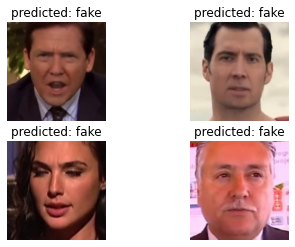

In [14]:
transform = transforms.Compose([transforms.Resize(299),
                                transforms.CenterCrop(299),
                                transforms.ToTensor()])

test_dataset = datasets.ImageFolder(
        '../input/deepfaketest/test',
        transform=transform)


test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1)

class_names = test_dataset.classes
visualize_model(model, class_names)